# Data Preparation

這篇筆記是記錄基本的資料讀取。

## 前期準備

### 基本設定

首先，我們先導入需要用到的函式庫，設定基本的參數與資料路徑。資料檔的欄位名稱儲存在 `header_file` 裡面。

In [1]:
# 載入函式庫
import numpy as np
import pandas as pd
import os, sys, csv

# 定義路徑
header_file = '../../data/readme.csv'
ST_PATH = '../../data/ST/'
VS_PATH = '../../data/VS/'

# 測試讀取欄位名稱
header = pd.read_csv(header_file).columns
header

Index(['Station', 'instrument', 'P', 'H', 'T', 'RH', 'U', 'V', 'Rad.'], dtype='object')

### 清點並檢查檔案

我們先利用 `os.walk()` 搜尋資料夾裡的所有檔案，擷取檔名裡的日期時間（YYYYMMDD_HH），然後把同時間的檔名放在同一列。

In [2]:
# Holders for data files
ST_files = []
VS_files = []

# Scan for ST files
for root, dirs, files in os.walk(ST_PATH): 
    for fn in files: 
        if fn.endswith('.csv'): 
             ST_files.append({'time':fn.replace('Banqiao_','').replace('_ST.csv',''), 'uri':os.path.join(root, fn)})
ST_files = pd.DataFrame(ST_files)

# Scan for VS files
for root, dirs, files in os.walk(VS_PATH): 
    for fn in files: 
        if fn.endswith('.csv'): 
             VS_files.append({'time':fn.replace('Banqiao_','').replace('_VS.csv',''), 'uri':os.path.join(root, fn)})
VS_files = pd.DataFrame(VS_files)

# Merge by time stamp
datafiles = pd.merge(VS_files, ST_files, on='time', suffixes=('_vs', '_st'))

print("VS files: "+str(VS_files.shape))
print("ST files: "+str(ST_files.shape))
print("After merging: "+str(datafiles.shape))
print(datafiles.head())

VS files: (412, 2)
ST files: (412, 2)
After merging: (412, 3)
          time                                    uri_vs  \
0  20180625_06  ../../data/VS/Banqiao_20180625_06_VS.csv   
1  20180626_00  ../../data/VS/Banqiao_20180626_00_VS.csv   
2  20180626_03  ../../data/VS/Banqiao_20180626_03_VS.csv   
3  20180627_03  ../../data/VS/Banqiao_20180627_03_VS.csv   
4  20180627_06  ../../data/VS/Banqiao_20180627_06_VS.csv   

                                     uri_st  
0  ../../data/ST/Banqiao_20180625_06_ST.csv  
1  ../../data/ST/Banqiao_20180626_00_ST.csv  
2  ../../data/ST/Banqiao_20180626_03_ST.csv  
3  ../../data/ST/Banqiao_20180627_03_ST.csv  
4  ../../data/ST/Banqiao_20180627_06_ST.csv  


### 讀取單一探空資料檔

接下來我們設計一個簡單的函數，給定探空資料檔案的路徑，就讀取內容並回傳。

In [3]:
# Function to read single sounding file in CSV format
def read_sounding_csv(furi, colnames=['Station', 'instrument', 'P', 'H', 'T', 'RH', 'U', 'V', 'Rad.'], verbose=0):
    import pandas as pd
    data = pd.read_csv(furi, names=colnames)
    if verbose>0:
        print('Read from file: '+furi+', data dimension: '+str(data.shape))
    return(data)

data_vs = read_sounding_csv(datafiles['uri_vs'].iloc[0], verbose=1)
print(data_vs.head())

data_st = read_sounding_csv(datafiles['uri_st'].iloc[0], verbose=1)
print(data_st.head())

Read from file: ../../data/VS/Banqiao_20180625_06_VS.csv, data dimension: (701, 9)
   Station instrument     P           H      T         RH     U     V  \
0  Banqiao         VS  1000   86.400012  31.50  62.920001  2.56 -0.66   
1  Banqiao         VS   999   96.000017  31.40  63.100000  2.70 -0.70   
2  Banqiao         VS   998  105.200020  31.32  63.180000  2.88 -0.70   
3  Banqiao         VS   997  116.000010  31.20  63.500000  3.00 -0.70   
4  Banqiao         VS   996  123.750020  31.10  63.725001  3.10 -0.70   

        Rad.  
0  1202.1257  
1  1202.1257  
2  1202.1257  
3  1202.1257  
4  1202.1257  
Read from file: ../../data/ST/Banqiao_20180625_06_ST.csv, data dimension: (701, 9)
   Station instrument     P          H          T         RH         U  \
0  Banqiao         ST  1000  144.16883  33.504632  62.417895 -1.217775   
1  Banqiao         ST   999  160.91323  33.362504  62.662493  2.042479   
2  Banqiao         ST   998  175.45446  33.183320  63.166699  5.502851   
3  Banqia

### 資料配對

我們需要將 storm-track (ST) 的 T 和 RH 校正到 Vaisala (VS) 的值，假設氣壓（P）的值兩邊都是正確的，因此配對完的資料應該有以下欄位：

- **time**: 觀測時間，格式為 YYYYMMDD_HH
- **P**: 氣壓值，假設兩種儀器是一致的
- **H_vs**: Vaisala 的高度
- **T_vs**: Vaisala 的溫度
- **RH_vs**: Vaisala 的相對濕度
- **U_vs**: Vaisala 的緯向風
- **V_vs**: Vaisala 的經向風
- **H_st**: storm-track 的高度
- **T_st**: storm-track 的溫度
- **RH_st**: storm-track 的相對濕度
- **U_st**: storm-track 的緯向風
- **V_st**: storm-track 的經向風



In [4]:
def create_aligned_data(timestamp, vsfile, stfile):
    vsdata = read_sounding_csv(vsfile, verbose=1)
    stdata = read_sounding_csv(stfile, verbose=1)
    data = vsdata.merge(stdata, on='P', suffixes=('_vs', '_st'))
    data = data.loc[:,['P','H_vs','T_vs','RH_vs','U_vs','V_vs', 
                       'H_st', 'T_st', 'RH_st', 'U_st', 'V_st']]
    data['time'] = timestamp
    data['key'] = data['time'] + '_' + data['P'].astype('str')
    return(data)

data = create_aligned_data(datafiles.iloc[0]['time'],datafiles.iloc[0]['uri_vs'], datafiles.iloc[0]['uri_st'])
print(data.shape)
print(data.head())


Read from file: ../../data/VS/Banqiao_20180625_06_VS.csv, data dimension: (701, 9)
Read from file: ../../data/ST/Banqiao_20180625_06_ST.csv, data dimension: (701, 9)
(701, 13)
      P        H_vs   T_vs      RH_vs  U_vs  V_vs       H_st       T_st  \
0  1000   86.400012  31.50  62.920001  2.56 -0.66  144.16883  33.504632   
1   999   96.000017  31.40  63.100000  2.70 -0.70  160.91323  33.362504   
2   998  105.200020  31.32  63.180000  2.88 -0.70  175.45446  33.183320   
3   997  116.000010  31.20  63.500000  3.00 -0.70  187.45056  33.025238   
4   996  123.750020  31.10  63.725001  3.10 -0.70  197.61818  32.892530   

       RH_st      U_st      V_st         time               key  
0  62.417895 -1.217775 -1.217775  20180625_06  20180625_06_1000  
1  62.662493  2.042479  2.042479  20180625_06   20180625_06_999  
2  63.166699  5.502851  5.502851  20180625_06   20180625_06_998  
3  63.756463  1.987596  1.987596  20180625_06   20180625_06_997  
4  64.291565  6.566753  6.566753  20180625_

### 校驗目標

我們進行資料校驗的目的，是要將 storm tracker 的紀錄調整成近似 Vaisala，我們有以下假設：

1. Vasala 的資料經過長期使用，已經被視為標準，我們假設這組資料是真實的觀測值。
2. 我們假設 storm-tracker 和 Vaisala 的氣壓值（P）是一致的，誤差主要發生在溫度（T）和濕度（RH）。
3. 高度（H）值是透過 P, T, RH 的公式換算來的，因此不直接校正。
4. 風場（U,V）是由 GPS 定位換算，故在此階段不校驗。

因此，我們實際上要利用 P, T_st, RH_st (或許再加上 U_st, V_st）來預測：
- **$\triangle T$** = T_vs - T_st
- **$\triangle RH$** = RH_vs - RH_st

接下來，我們要製作包含 $\triangle T$ 和 $\triangle RH$ 的資料集。

In [7]:
# Create dataset with X(input) and Y(output)
def create_iodata(timestamp, vsfile, stfile):
    # Read in ST and VS data
    vsdata = read_sounding_csv(vsfile, verbose=0)
    stdata = read_sounding_csv(stfile, verbose=0)
    # Align two dataset with P
    data = vsdata.merge(stdata, on='P', suffixes=('_vs', '_st'))
    # Insert unique keys for indexing
    data['time'] = timestamp
    data['key'] = timestamp + '_' + data['P'].astype('str')
    # Calculate delta_T and delta_RH
    data['dT'] = (data['T_vs'] - data['T_st'])
    data['dRH'] = (data['RH_vs'] - data['RH_st'])
    # Select only necessary columes
    data = data.loc[:,['key','time','P','T_st','RH_st','U_st','V_st','dT','dRH']]
    data.set_index('key', inplace=True)
    return(data)

x = create_iodata(datafiles.iloc[0]['time'],datafiles.iloc[0]['uri_vs'], datafiles.iloc[0]['uri_st'])

print(x.head())

                         time     P       T_st      RH_st      U_st      V_st  \
key                                                                             
20180625_06_1000  20180625_06  1000  33.504632  62.417895 -1.217775 -1.217775   
20180625_06_999   20180625_06   999  33.362504  62.662493  2.042479  2.042479   
20180625_06_998   20180625_06   998  33.183320  63.166699  5.502851  5.502851   
20180625_06_997   20180625_06   997  33.025238  63.756463  1.987596  1.987596   
20180625_06_996   20180625_06   996  32.892530  64.291565  6.566753  6.566753   

                        dT       dRH  
key                                   
20180625_06_1000 -2.004632  0.502106  
20180625_06_999  -1.962504  0.437507  
20180625_06_998  -1.863320  0.013301  
20180625_06_997  -1.825238 -0.256463  
20180625_06_996  -1.792530 -0.566564  


### 簡易的視覺化

有了這個資料集，我們可以把某一次探空的資料快速的視覺化，以下我們觀察一下需要校驗誤差的垂直分佈：

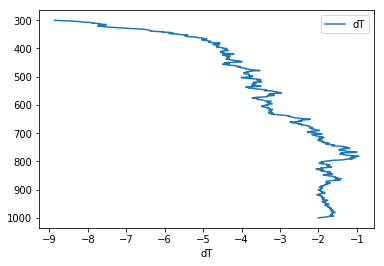

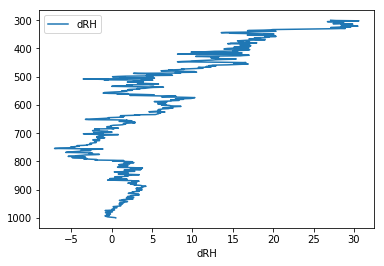

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

x.plot(x='dT', y='P', label='dT')
plt.gca().invert_yaxis()
x.plot(x='dRH', y='P', label='dRH')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

我們可以看到，在這次探空裡，溫度和相對濕度的誤差，都是隨著高度增加。接下來，我們要利用前面的幾個函數，將多次探空的資料堆疊在一起，形成一個大的資料集。

In [24]:
# Create data frame with the first entry
data = create_iodata(datafiles.iloc[0]['time'],datafiles.iloc[0]['uri_vs'], datafiles.iloc[0]['uri_st'])
# Stack other observation
for i in range(1, datafiles.shape[0]):
    tmp = create_iodata(datafiles.iloc[i]['time'],datafiles.iloc[i]['uri_vs'], datafiles.iloc[i]['uri_st'])
    data = data.append(tmp)

# Check data size
print(data.shape)

(261231, 8)


In [26]:
# Write to file
print(data.head())
data.to_csv('../data/iodata.csv')

                         time       P       T_st      RH_st      U_st  \
key                                                                     
20180625_06_1000  20180625_06  1000.0  33.504632  62.417895 -1.217775   
20180625_06_999   20180625_06   999.0  33.362504  62.662493  2.042479   
20180625_06_998   20180625_06   998.0  33.183320  63.166699  5.502851   
20180625_06_997   20180625_06   997.0  33.025238  63.756463  1.987596   
20180625_06_996   20180625_06   996.0  32.892530  64.291565  6.566753   

                      V_st        dT       dRH  
key                                             
20180625_06_1000 -1.217775 -2.004632  0.502106  
20180625_06_999   2.042479 -1.962504  0.437507  
20180625_06_998   5.502851 -1.863320  0.013301  
20180625_06_997   1.987596 -1.825238 -0.256463  
20180625_06_996   6.566753 -1.792530 -0.566564  
